In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import math
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
#####################
#Auther: Ruojun

# Problem 2
1. load file 'chronic_kidney_disease_full.arff'
2. logistic regression with L1-REGULARIZATION
3. Plot f1 score vs different lambda

## load file
1. The row with missing data is deleted
2. Replace the text attribute with integer 0,1,such as(poor:0,good:1)
3. Replace the label of kidney disease with (notckd:0,ckd:1)  


In [2]:
def load_file_save(file_name):
    if not os.path.isfile('train.txt'):
        ####################
        #load file
        file = open(file_name)
        file_data = file.readlines()
        features = file_data[28:53]
        data = [line.strip().split(',') for line in file_data[145:545]]
        data.remove(data[369])
        dataframe = sklearn.utils.shuffle(pd.DataFrame(data))
        dataframe.drop(columns=25)
        ########################
        #drop missing data
        debug1 = dataframe == '?'
        drop_result = dataframe[debug1.sum(1) == 0]
        drop_result[24] = drop_result[24].map({'notckd': 0, 'ckd': 1})
        drop_result[5] = drop_result[5].map({'normal': 0, 'abnormal': 1})
        drop_result[6] = drop_result[6].map({'normal': 0, 'abnormal': 1})
        drop_result[7] = drop_result[7].map({'present': 0, 'notpresent': 1})
        drop_result[8] = drop_result[8].map({'present': 0, 'notpresent': 1})
        drop_result[18] = drop_result[18].map({'no': 0, 'yes': 1})
        drop_result[19] = drop_result[19].map({'no': 0, 'yes': 1})
        drop_result[20] = drop_result[20].map({'no': 0, 'yes': 1})
        drop_result[21] = drop_result[21].map({'poor': 0, 'good': 1})
        drop_result[22] = drop_result[22].map({'no': 0, 'yes': 1})
        drop_result[23] = drop_result[23].map({'no': 0, 'yes': 1})
        ########################
        #Split train and test
        train_data = drop_result[0:int(len(drop_result)*0.8)]
        test_data = drop_result[int(len(drop_result)*0.8):]
        train_data.to_csv('train.txt',header=False,index=False)
        test_data.to_csv('test.txt',header=False,index=False)
    train_x = np.asarray(pd.read_csv('train.txt', header=None))[:, 0:23]
    test_x = np.asarray(pd.read_csv('test.txt', header=None))[:, 0:23]
    train_y = np.asarray(pd.read_csv('train.txt', header=None))[:, 24]
    test_y = np.asarray(pd.read_csv('test.txt', header=None))[:, 24]
    return train_x,train_y,test_x,test_y


## Logistic regression
1. Intialize the parameters w with random value; b is zero.
2. Activation Function is the sigmoid function.
3. Cost consists of reularization costand cross entropy cost.
4. Optimising the parameters by the gradiend of cost function.
5. Caculate the f1_score

In [3]:

def sigmoid(Z):
    S = 1 / (1 + np.exp(-Z))
    return S

def initialize(dim,ini_type):
    if ini_type=='zeros':
        w = np.zeros((dim,1))
    else:
        w = np.random.rand(dim, 1)/24
    b = 0
    return w, b

def compute_cost_regularization(A,W,Y,lambd=0):
    m = np.size(A)
    cost_ce = 0
    for i in range(len(Y)):
        a = A[0,i]
        y = Y[i]
        if a ==1:
            cost_ce += -y*math.log(a)+(1-y)*1e2
        elif a ==0:
            cost_ce += -(1-y)*math.log(1-a)+y*1e2
        else:
            cost_ce += -y*math.log(a)-(1-y)*math.log(1-a)
    cost_regu = lambd * (np.sum(np.square(W)))
    cost = cost_ce/m + cost_regu/2/m
    return cost


def propagate(w, b, X, Y,lambd):
    m = X.shape[1]
    B = np.dot(w.T, X) + b
    A = sigmoid(B)  # compute activation
    cost = compute_cost_regularization(A,w,Y)
    dw = np.dot(X, np.transpose(A - Y)) / m + w*lambd/m
    db = np.mean(A - Y)
    grads = {"dw": dw,
             "db": db}
    return grads, cost


def optimize(w, b, X, Y, num_iterations, learning_rate,lambd):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y,lambd)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 1000 == 0:
            costs.append(cost)
            #print("Cost after iteration %i: %f" % (i, cost))
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    return params, grads, costs


def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0

    return Y_prediction


def model(X_train, Y_train, X_test, Y_test, ini_type='zeros', num_iterations=5000, learning_rate=0.01,lambd=0.1):
    # initialize parameters with zeros
    dim = X_train.shape[0]
    w, b = initialize(dim,ini_type)

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, lambd)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    f1_test = f1_score(Y_test,Y_prediction_test.reshape(np.size(Y_test)))
    f1_train = f1_score(Y_train, Y_prediction_train.reshape(np.size(Y_train)))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations,
         "f_measure_test": f1_test,
         "f_measure_train": f1_train}

    return d
def f_measure(y_hat,y):
    TP = 0
    FP = 0
    FN = 0
    for i in range(np.size(y)):
        if np.allclose(y[i], 1., atol=1e-3)&np.allclose(y_hat[0,i], 1.,atol=1e-3):TP +=1
        elif np.allclose(y[i], 1., atol=1e-3) & np.allclose(y_hat[0,i], 0., atol=1e-3): FP += 1
        elif np.allclose(y[i], 0., atol=1e-3) & np.allclose(y_hat[0,i], 1., atol=1e-3): FN += 1
    PRE = TP/(TP+FP)
    REC = TP/(TP+FN)
    f_measure = (2*PRE*REC)/(PRE+REC)
    return f_measure


## Plot
1. Use load function to get 80% splitted train and test data
2. Use logistic model with different lambda
3. Plot the figure 

In [4]:
file = 'chronic_kidney_disease_full.arff'
train_x,train_y,test_x,test_y = load_file_save(file)
print("train data:",np.shape(train_x))
print("test data:",np.shape(test_x))

train data: (125, 23)
test data: (32, 23)


c:\users\ruojun li\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


train accuracy: 98.4 %
test accuracy: 96.875 %
train accuracy: 71.2 %
test accuracy: 78.125 %


c:\users\ruojun li\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy: 83.2 %
test accuracy: 84.375 %
train accuracy: 80.0 %
test accuracy: 81.25 %
train accuracy: 71.2 %
test accuracy: 78.125 %
train accuracy: 71.2 %
test accuracy: 78.125 %
train accuracy: 28.799999999999997 %
test accuracy: 21.875 %
train accuracy: 80.0 %
test accuracy: 81.25 %
train accuracy: 71.2 %
test accuracy: 78.125 %
train accuracy: 80.0 %
test accuracy: 81.25 %
train accuracy: 78.4 %
test accuracy: 81.25 %
train accuracy: 79.2 %
test accuracy: 81.25 %
train accuracy: 80.0 %
test accuracy: 81.25 %
train accuracy: 71.2 %
test accuracy: 78.125 %
train accuracy: 72.0 %
test accuracy: 78.125 %
train accuracy: 28.799999999999997 %
test accuracy: 21.875 %
train accuracy: 28.799999999999997 %
test accuracy: 21.875 %
train accuracy: 28.799999999999997 %
test accuracy: 21.875 %
train accuracy: 28.799999999999997 %
test accuracy: 21.875 %
train accuracy: 89.6 %
test accuracy: 93.75 %
train accuracy: 72.0 %
test accuracy: 78.125 %
train accuracy: 84.8 %
test accuracy: 84.375

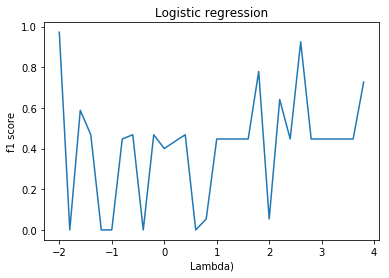

In [5]:
F_measure_train = []
F_measure_test = []
lamda_range = np.arange(-2,4,0.2)
for lamda in lamda_range:
    d = model(train_x.T, train_y, test_x.T, test_y, lambd=lamda)
    F_measure_train.append(d["f_measure_train"])
    F_measure_test.append(d["f_measure_test"])

fig, ax = plt.subplots()
plt.plot(lamda_range,F_measure_train)
ax.set(xlabel='Lambda)', ylabel='f1 score',
           title="Logistic regression")
plt.show()

## Standardization
### 1. Equation : 
\begin{equation}
x_i =  \frac{x_i-\mu}{\sigma} \quad
\end{equation}
### 2 . Repeat part b and plot figure

In [6]:
def standard(train_x,test_x):
    data = np.append(train_x, test_x, axis=0)
    std_x = np.std(data,0)
    mean_x = np.mean(data,0)
    train_x_std = (train_x - mean_x)/std_x
    test_x_std = (test_x - mean_x)/std_x
    return train_x_std,test_x_std

train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accuracy: 100.0 %
test accuracy: 100.0 %
train accurac

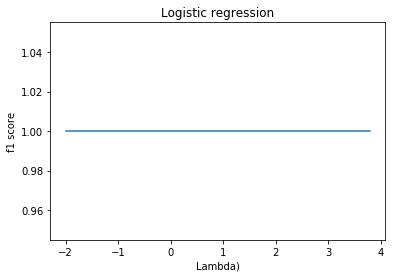

In [7]:
F_measure_train = []
F_measure_test = []
lamda_range = np.arange(-2,4,0.2)
train_x,test_x = standard(train_x,test_x)
for lamda in lamda_range:
    d = model(train_x.T, train_y, test_x.T, test_y, lambd=lamda)
    F_measure_train.append(d["f_measure_train"])
    F_measure_test.append(d["f_measure_test"])

fig, ax = plt.subplots()
plt.plot(lamda_range,F_measure_train)
ax.set(xlabel='Lambda)', ylabel='f1 score',
           title="Logistic regression")
plt.show()